# <center>3. Дерева рішень, метод найближчого сусіда та лінійні моделі</center>
## <center>3.1 Дерева рішень та модель найближчого сусіда</center>


Спочатку налаштуємо доступ до даних на google drive (якщо ви відкриваєте блокнот в google colab, а не на PC) шляхом монтування google drive


In [2]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


Перевіримо шлях до папки з матеріалами лаборатоної роботи на google drive.
Якщо у вас шлях відрізняється то відредагуйте


In [3]:
!ls gdrive/MyDrive/TEACHING/IntroDataScience/intro_to_data_science/Lec_topic_3

data			     lec_3.1_trees_knn.pdf
img			     lec_3.2_linear_models_eng.ipynb
lec_3.1_trees_knn_eng.ipynb  lec_3.2_linear_models_eng.pdf
lec_3.1_trees_knn_eng.pdf    lec_3.2_linear_models.ipynb
lec_3.1_trees_knn.ipynb      lec_3.2_linear_models.pdf


Перемістимо матеріали лабораторної роботи з google drive на віртуальну машину google colab

In [4]:
!cp -a gdrive/MyDrive/TEACHING/IntroDataScience/intro_to_data_science/Lec_topic_3/. .
!ls

data			     lec_3.1_trees_knn.pdf
gdrive			     lec_3.2_linear_models_eng.ipynb
img			     lec_3.2_linear_models_eng.pdf
lec_3.1_trees_knn_eng.ipynb  lec_3.2_linear_models.ipynb
lec_3.1_trees_knn_eng.pdf    lec_3.2_linear_models.pdf
lec_3.1_trees_knn.ipynb      sample_data


<habracut/>
Класичне, загальне визначення машинного навчання звучить так (T. Mitchell "Machine learning", 1997): "кажуть, що комп'ютерна програма *навчається* при вирішенні якогось завдання з класу *T*, якщо її продуктивність, згідно метриці *P*, поліпшується при накопиченні досвіду *E* ".

Далі в різних сценаріях під * T, P *, і * E * маються на увазі зовсім різні речі. Серед найпопулярніших завдань * T * в машинному навчанні:
 - класифікація - віднесення об'єкта до однієї з категорій на підставі його ознак
 - регресія - прогнозування кількісної ознаки об'єкта на підставі інших його ознак
 - кластеризація - розбиття множини об'єктів на групи на підставі ознак цих об'єктів так, щоб усередині груп об'єкти були схожі між собою, а поза однією групою - менш схожі
 - детектування аномалій - пошук об'єктів, "сильно несхожих" на всі інші у вибірці або на якусь групу об'єктів
 - і багато інших, більш специфічних. Хороший огляд дано в 5 розділі книги "Deep Learning" (Ian Goodfellow, Yoshua Bengio, Aaron Courville, 2016)
 
Під досвідом *E* розуміються дані (без них нікуди), і в залежності від цього алгоритми машинного навчання можуть бути поділені на ті, що навчаються *з учителем* і *без учителя* (supervised & unsupervised learning). У завданнях навчання без вчителя є *вибірка*, яка складається з* об'єктів *, що описуються набором *ознак*. У завданні навчання з учителем на додачу до цього для кожного об'єкта деякої вибірки, яку ще називають *навчальною*, відома *цільова ознака* - по суті це те, що хотілося б прогнозувати для об'єктів поза навчальною вибіркою.

#### Приклад
Завдання класифікації і регресії - це завдання навчання з учителем. Як приклад, розглянемо завдання кредитного скорингу: на основі накопичених банком даних про своїх клієнтів є потреба прогнозувати неповернення кредиту. Тут для алгоритму досвід *E* - це наявна навчальна вибірка: набір *об'єктів* (людей), кожен з яких характеризується набором *ознак* (таких як вік, зарплата, тип кредиту, неповернення в минулому і т.д.), а також *цільовим ознакою*. Якщо ця цільова ознака - просто факт неповернення кредиту (1 або 0, тобто банк знає про своїх клієнтів, хто повернув кредит, а хто - ні), то це завдання (бінарної) класифікації. Якщо відомо, *на скільки* за часом клієнт затягнув з поверненням кредиту і хочеться те ж саме прогнозувати для нових клієнтів, то це буде завданням регресії.

Нарешті, третя абстракція у визначенні машинного навчання - це метрика оцінки продуктивності алгоритму *P*. Такі метрики розрізняються для різних завдань і алгоритмів, і про них ми будимо говорити в міру вивчення алгоритмів. Поки скажімо, що найпростіша метрика якості алгоритму для вирішення завдання класифікації - це частка правильних відповідей (*accuracy*, не називайте її *точністю , цей переклад зарезервований під іншу метрику, *precision*) - то є просто частка вірних прогнозів алгоритму на тестової вибірці.

Далі будемо говорити про два завдання навчання з учителем: про класифікацію і регресію.

## Дерево рішень
Почнемо огляд методів класифікації і регресії з одного з найпопулярніших - з дерева рішень. Дерева рішень використовуються в повсякденному житті в найрізноманітніших сферах людської діяльності, часом і дуже далеких від машинного навчання. Деревом рішень можна назвати наочну інструкцію, що робити в якій ситуації. Наведемо приклад з області консультування наукових співробітників інституту. Сумський державний університет випускає інфо-схеми, що полегшують життя своїм співробітникам. Ось фрагмент інструкції щодо публікації наукової статті на порталі університету.


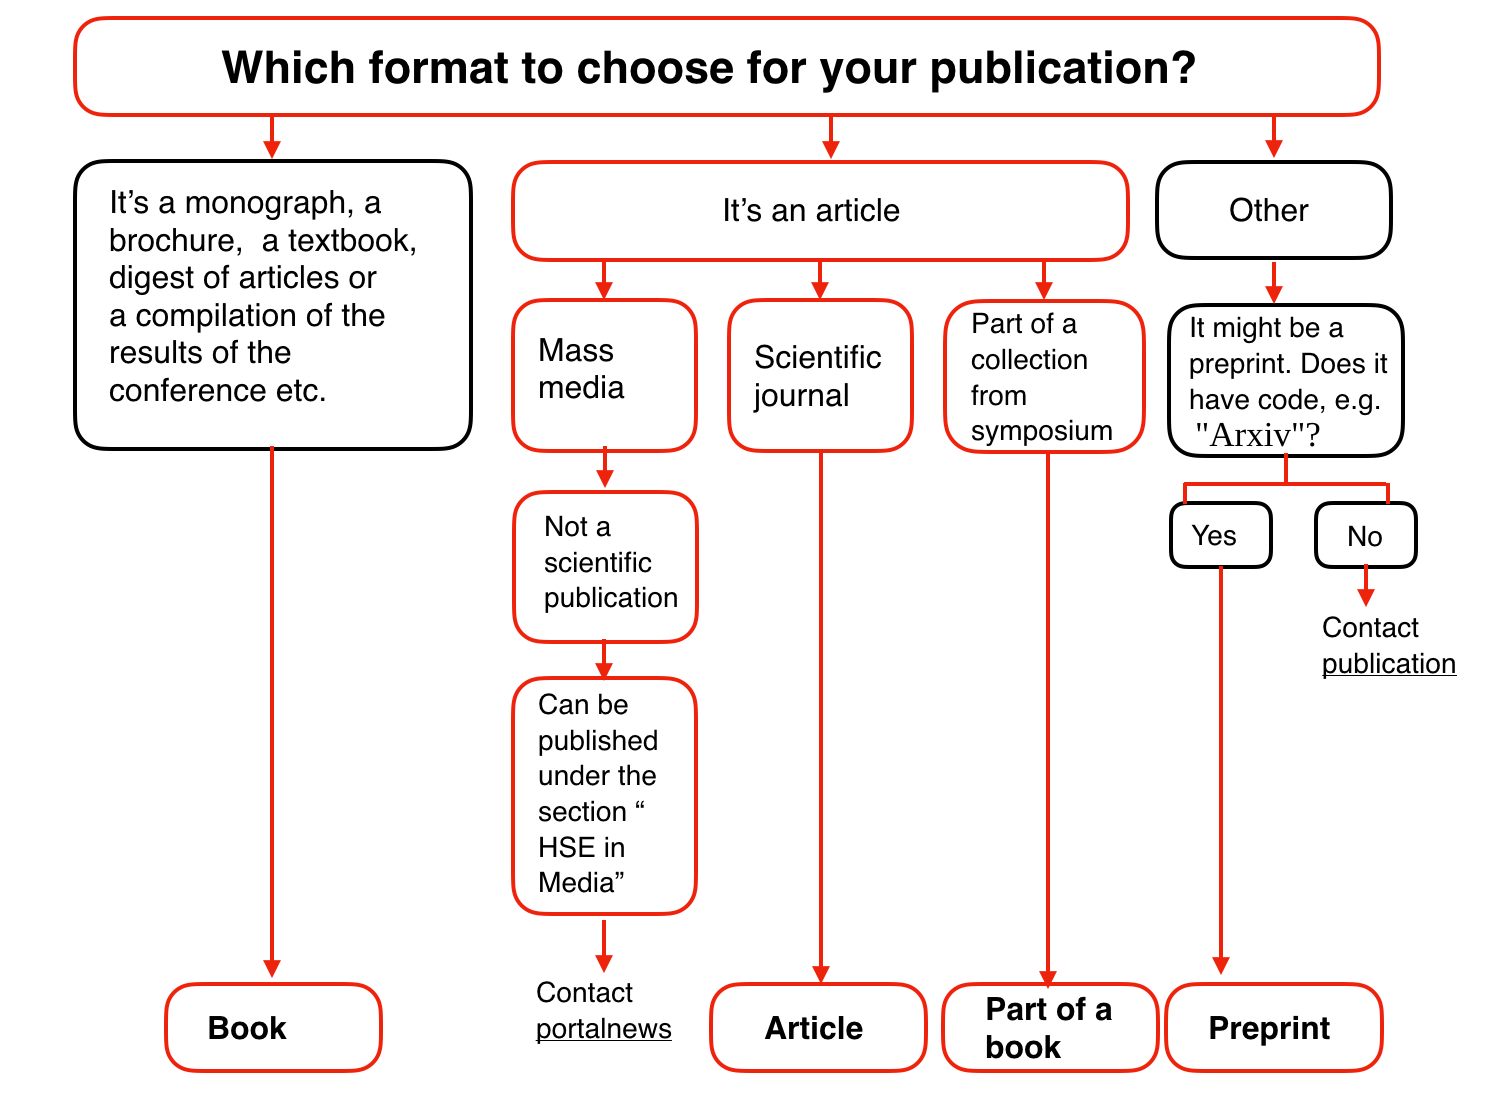

In [7]:
from IPython.display import Image
Image('img/topic3_hse_instruction.png', width=640, height=480)

У термінах машинного навчання можна сказати, що це елементарний класифікатор, який визначає форму публікації на порталі (книга, стаття, глава книги, препринт, публікація) за кількома ознаками: типом публікації (монографія, брошура, стаття і т.д.), типу видання, де опублікована стаття (науковий журнал, збірник праць і т.д.) і іншим.



Найчастіше дерево рішень служить узагальненням досвіду експертів, засобом передачі знань майбутнім співробітникам або моделлю бізнес-процесу компанії. Наприклад, до впровадження масштабованих алгоритмів машинного навчання в банківській сфері завдання кредитного скорингу вирішувалося експертами. Рішення про видачу кредиту позичальникові приймалося на основі деяких інтуїтивно (або з досвіду) виведених правил, які можна представити у вигляді дерева рішень.



## Як будується дерево рішень

У прикладі з кредитним скорингом ми бачили, що рішення про видачу кредиту приймалося на основі віку, наявності нерухомості, доходу та інших ознак. Але яка буде ознака вибрана першою? Для цього розглянемо більш простий приклад, де всі ознаки бінарні.

Тут можна згадати гру "20 запитань", яка часто згадується у вступі в дерева рішень. Напевно кожен в неї грав. Одна людина загадує знаменитість, а друга намагається відгадати, задаючи лише питання, на які можна відповісти "Так" або "Ні" (опустимо варіанти "не знаю" і "не можу сказати"). Яке питання слід задати насамперед? Звичайно, таке, яке найсильніше зменшить кількість варіантів, що залишилися. Наприклад, питання "Це Анджеліна Джолі?" в разі негативної відповіді залишить понад 6 мільярдів варіантів для подальшого перебору (звичайно, трохи менше, не кожна людина - знаменитість, але все одно чимало), а ось питання "Це жінка?" відсіче вже близько половини знаменитостей. Тобто, ознака "стать" набагато краще розділяє вибірку людей, ніж ознака "це Анджеліна Джолі", "національність-іспанець" або "любить футбол". Це інтуїтивно відповідає поняттю приросту інформації, як міри зменшення ентропії.

#### Ентропія
Ентропія Шеннона визначається для системи з $ N $ можливими станами наступним чином:

$$\Large S = -\sum_{i=1}^{N}p_ilog_2p_i,$$

де $ p_i $ - ймовірність знаходження системи в $ i $ -му стані. Це дуже важливе поняття, яке використовується в фізиці, теорії інформації та інших областях. Опускаючи передумови запровадження (комбінаторні і теоретико-інформаційні) цього поняття, зазначимо, що, інтуїтивно, ентропія відповідає ступеню хаосу в системі. Чим вище ентропія, тим менш впорядкована система і навпаки. Це допоможе нам формалізувати "ефективний розподіл вибірки", про який ми говорили в контексті гри "20 запитань".

<h4>Приклад</h4>
Для ілюстрації того, як ентропія допоможе визначити хороші ознаки для побудови дерева, наведемо 'іграшковий' приклад. Будемо передбачати колір кульки за її координатами. Звичайно, нічого спільного з життям це не має, але дозволяє показати, як ентропія використовується для побудови дерева рішень.
<img src="https://habrastorage.org/files/c96/80a/a4b/c9680aa4babc40f4bbc8b3595e203979.png"/><br>

Тут 9 синіх кульок і 11 жовтих. Якщо ми навмання витягли кульку, то вона з ймовірністю   $p_1=\frac{9}{20}$ буде синьою і з ймовірністю  $p_2=\frac{11}{20}$ – жовтою. Це означає, що ентропія стану  $S_0 = -\frac{9}{20}log_2{\frac{9}{20}}-\frac{11}{20}log_2{\frac{11}{20}} \approx 1$. Саме це значення поки ні про що нам не говорить. Тепер подивимося, як зміниться ентропія, якщо розбити кульки на дві групи - з координатою менше або дорівнює 12 і більше 12.
<img src="https://habrastorage.org/files/186/444/a8b/186444a8bd0e451c8324ca8529f8d4f4.png"/><br>

У лівій групі виявилося 13 куль, з яких 8 синіх і 5 жовтих. Ентропія цієї групи дорівнює $S_1 = -\frac{5}{13}log_2{\frac{5}{13}}-\frac{8}{13}log_2{\frac{8}{13}} \approx 0.96$. У правій групі виявилося 7 куль, з яких 1 синя і 6 жовтих. Ентропія правої групи дорівнює $S_2 = -\frac{1}{7}log_2{\frac{1}{7}}-\frac{6}{7}log_2{\frac{6}{7}} \approx 0.6$. Як бачимо, ентропія зменшилася в обох групах у порівнянні з початковим станом, хоч в лівій і не сильно. Оскільки ентропія - по суті ступінь хаосу (або невизначеності) в системі, зменшення ентропії називають приростом інформації. Формально приріст інформації (information gain, IG) при розбитті вибірки за ознакою $Q$ (в нашому прикладі це ознака "$x \leq 12$") визначається як
$$\Large IG(Q) = S_O - \sum_{i=1}^{q}\frac{|N_i|}{N}S_i,$$
де $q$ – число груп після розбиття, $N_i$ – число елементів вибірки, у яких ознака $Q$ має $i$-те значення. У нашому випадку після поділу вийшло дві групи ($q = 2$) – одна з 13 елементів ($N_1 = 13$), друга – з 7 ($N_2 = 7$). Приріст інформації вийшов

$$\Large IG("x \leq 12") = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16.$$
Виходить, розділивши кульки на дві групи за ознакою "координата менше або дорівнює 12", ми вже отримали більш впорядковану систему, ніж на початку. Продовжимо розподіл кульок на групи до тих пір, доки в кожній групі кульки не будуть одного кольору.


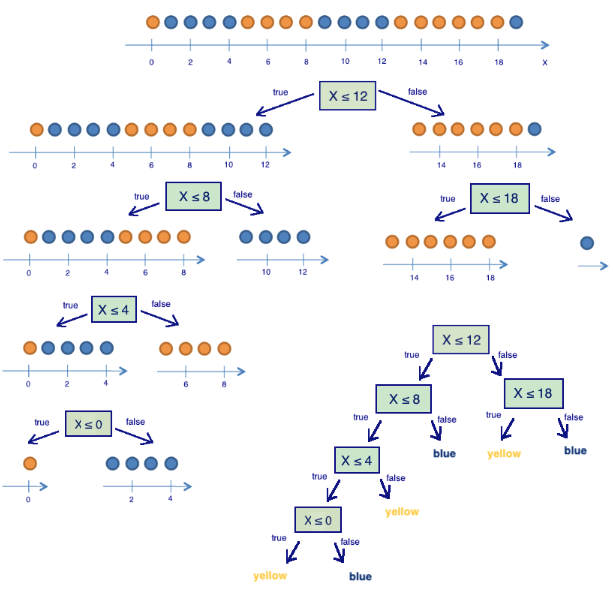

In [5]:
from IPython.display import Image
Image("img/o4nxp7itpg_zxowtmffs5xh3bbw.png")  #, width=640, height=480)

Для правої групи було потрібно всього одне додаткове розбиття за ознакою "координата менша або дорівнює 18", для лівої - ще три. Очевидно, ентропія групи з кульками одного кольору дорівнює 0 ($ log_2 {1} = 0 $), що відповідає уявленню, що група кульок одного кольору - впорядкована.
У підсумку ми побудували дерево рішень, яке пророкує колір кульки за її  координатою. Відзначимо, що таке дерево рішень може погано працювати для нових об'єктів (визначення кольору нових кульок), оскільки воно ідеально підлаштоване під навчальну вибірку (початкові 20 кульок). Для класифікації нових кульок краще підійде дерево з меншим числом "питань", або поділів, нехай навіть воно і не ідеально розбиває за кольорами навчальну вибірку. Цю проблему, перенавчання, ми ще розглянемо далі.

#### Алгоритм побудови дерева

Можна переконатися в тому, що побудоване в попередньому прикладі дерево є в деякому сенсі оптимальним - треба було тільки 5 "питань" (умов для ознаки $ x $), щоб "підігнати" дерево рішень під навчальну вибірку, тобто щоб дерево правильно класифікувало будь-який навчальний об'єкт. За інших умов поділу вибірки дерево вийде глибше.

В основі популярних алгоритмів побудови дерева рішень, таких як ID3 і C4.5, лежить принцип жадібної максимізації приросту інформації - на кожному кроці вибирається та ознака, при поділі за якою приріст інформації виявляється найбільшим. Далі процедура повторюється рекурсивно, доки ентропія не опиниться рівною нулю або якійсь малій величині (якщо дерево не підганяється ідеально під навчальну вибірку щоб уникнути перенавчання).
У різних алгоритмах застосовуються різні евристики для "ранньої зупинки" або "відсікання", щоб уникнути побудови перенавчання дерева.

```python
def build(L):
    create node t
    if the stopping criterion is True:
        assign a predictive model to t
    else:
        Find the best binary split L = L_left + L_right
        t.left = build(L_left)
        t.right = build(L_right)
    return t     
    
```

#### Інші критерії якості розбиття в завданні класифікації

Ми розібралися, в тому, як поняття ентропії дозволяє формалізувати уявлення про якість розбиття в дереві. Але це всього-лише евристика, існують і інші:

 - Невизначеність Джині (Gini impurity):  $G = 1 - \sum\limits_k (p_k)^2$. Максимізацію цього критерію можна інтерпретувати як максимізацію числа пар об'єктів одного класу, які опинилися в одному піддереві. Не плутати з індексом Джині! 
 - Помилка класифікації (misclassification error):  $E = 1 - \max\limits_k p_k$
 
 
На практиці помилка класифікації майже не використовується, а невизначеність Джині і приріст інформації працюють майже однаково.

У разі завдання бінарної класифікації ($p_+$ - ймовірність об'єкта мати мітку +) ентропія і невизначеність Джині приймуть такий вигляд:<br><br>
$$ S = -p_+ \log_2{p_+} -p_- \log_2{p_-} = -p_+ \log_2{p_+} -(1 - p_{+}) \log_2{(1 - p_{+})};$$
$$ G = 1 - p_+^2 - p_-^2 = 1 - p_+^2 - (1 - p_+)^2 = 2p_+(1-p_+).$$

Коли ми побудуємо графіки цих двох функцій від аргументу $p_+$,то побачимо, що графік ентропії дуже близький до графіка подвоєної невизначеності Джині, і тому на практиці ці два критерії "працюють" майже однаково.

In [6]:
from __future__ import division, print_function

import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


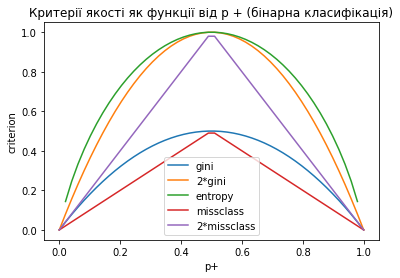

In [7]:
plt.rcParams['figure.figsize'] = (6,4)
xx = np.linspace(0,1,50)
plt.plot(xx, [2 * x * (1-x) for x in xx], label='gini')
plt.plot(xx, [4 * x * (1-x) for x in xx], label='2*gini')
plt.plot(xx, [-x * np.log2(x) - (1-x) * np.log2(1 - x)  for x in xx], label='entropy')
plt.plot(xx, [1 - max(x, 1-x) for x in xx], label='missclass')
plt.plot(xx, [2 - 2 * max(x, 1-x) for x in xx], label='2*missclass')
plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Критерії якості як функції від p + (бінарна класифікація)')
plt.legend();

#### Приклад
Розглянемо приклад застосування дерева рішень з бібліотеки Scikit-learn для синтетичних даних. Згенеруємо дані. Два класи будуть згенеровані з двох нормальних розподілів з різними середніми.

In [8]:
# перший клас
np.random.seed(7)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# додаємо другий клас
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

Напишемо допоміжну функцію, яка буде повертати сітку для подальшої красивої візуалізації.

In [9]:
def get_grid(data, eps=0.01):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, eps),
                         np.arange(y_min, y_max, eps))

Відобразимо дані. Неформально, завдання класифікації в цьому випадку - побудувати якусь "хорошу" межу, що розділяє 2 класи (червоні точки від жовтих). Якщо перебільшувати, то машинне навчання в цьому випадку зводиться до того, як вибрати хорошу розділяючу межу. Можливо, пряма буде занадто простою межею, а якась складна крива, що обгинає кожну червону крапку - буде занадто складною і будемо часто помилятися на нових прикладах з того ж розподілу, з якого прийшла навчальна вибірка. Інтуїція підказує, що добре на нових даних буде працювати якась * гладка * межа, що розділяє 2 класи, або хоча б просто пряма (в $n$ -мірному випадку - гіперплощина).

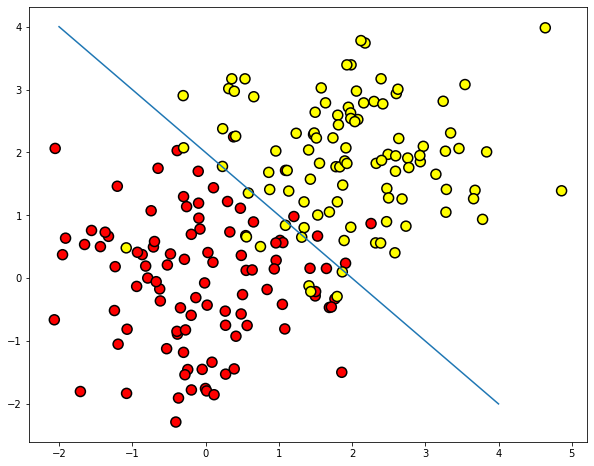

In [10]:
plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1));

Спробуємо розділити ці два класи, навчивши дерево рішень. У дереві будемо використовувати параметр `max_depth`, що обмежує глибину дерева. Візуалізіруємо отриманий кордон поділу класів.

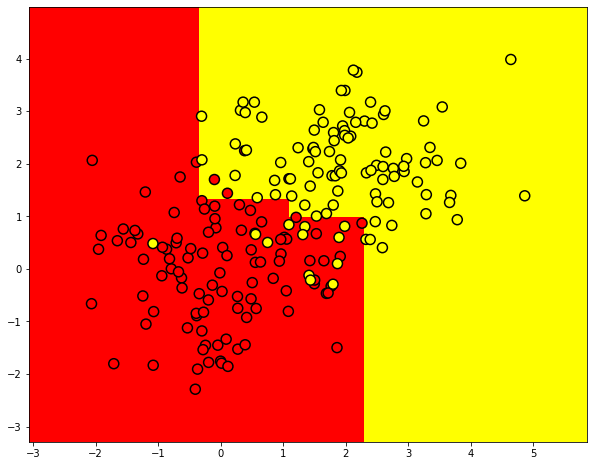

In [12]:
from sklearn.tree import DecisionTreeClassifier

# Параметр min_samples_leaf вказує, при якому мінімальному кількості
# Елементів в вузлі він буде далі поділятися
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# навчаємо дерево
clf_tree.fit(train_data, train_labels)
# Трохи коду для відображення розділяючої поверхні
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);

А як виглядає саме побудоване дерево? Бачимо, що дерево "нарізає" простір на 7 прямокутників (в дереві 7 листків). У кожному такому прямокутнику прогноз дерева буде сталим, за переважанням об'єктів того чи іншого класу.

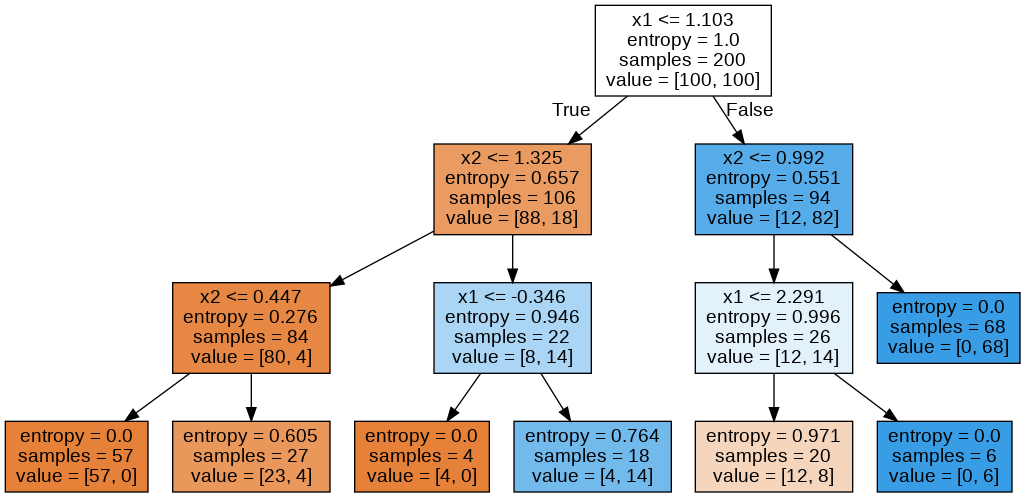

In [13]:
#використовуємо .dot формат для візуалізації дерева
from sklearn.tree import export_graphviz
export_graphviz(clf_tree, feature_names=['x1', 'x2'], 
                out_file='img/small_tree.dot', filled=True)

!dot -Tpng img/small_tree.dot -o img/small_tree.png
!rm img/small_tree.dot

from IPython.display import Image
Image('img/small_tree.png', width=640, height=480)


Як "читається" таке дерево?

На початку було 200 об'єктів, 100 - одного класу і 100 - другого. Ентропія початкового стану була максимальною - 1. Потім було зроблено розбиття об'єктів на 2 групи в залежності від порівняння ознаки $x_1$ зі значенням $1.1034$ (знайдіть цю ділянку межі на рисунку вище, до дерева). При цьому ентропія і в лівій, і в правій групі об'єктів зменшилася. І так далі, дерево будується до глибини 3. При такій візуалізації чим більше об'єктів одного класу, тим колір вершини ближче до темно-помаранчевого і, навпаки, чим більше об'єктів другого класу, тим ближче колір до темно-синього. На початку об'єктів одного класу порівну, тому коренева вершина дерева - білого кольору.

### Як дерево рішень працює з кількісними ознаками

Припустимо, у вибірці є кількісна ознака "Вік", яка має багато унікальних значень. Дерево рішень буде шукати краще (за критерієм типу приросту інформації) розбиття вибірки, перевіряючи бінарні ознаки типу "Вік <17", "Вік <22.87" і т.д. Але що якщо таких "нарізань" віку занадто багато? А що якщо є ще кількісна ознака "Зарплата", і зарплату теж можна «нарізати» великим числом способів? Виходить дуже багато бінарних ознак для вибору кращого на кожному кроці побудови дерева. Для вирішення цієї проблеми застосовують евристики для обмеження числа порогів, з якими ми порівнюємо кількісну ознаку.

Розглянемо це на іграшковому прикладі. Нехай є наступна вибірка:

In [14]:
data = pd.DataFrame({'Вік': [17,64,18,20,38,49,55,25,29,31,33], 
             'неповернення_кредиту': [1,0,1,0,1,0,0,1,1,0,1]})

In [15]:
data

,Вік,неповернення_кредиту
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


Відсортуємо її по зростанню віку.

In [16]:
data.sort_values('Вік')

,Вік,неповернення_кредиту
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


Навчимо на цих даних дерево рішень (без обмеження глибини) і подивимося на нього.

In [17]:
age_tree = DecisionTreeClassifier(random_state=17)
age_tree.fit(data['Вік'].values.reshape(-1, 1), data['неповернення_кредиту'].values)

DecisionTreeClassifier(random_state=17)

Бачимо, що дерево задіяло 5 значень, з якими порівнюється вік: 43.5, 19, 22.5, 30 і 32 роки. Якщо придивитися, то це якраз середні значення між віками, при яких цільовий клас "змінюється" з 1 на 0 або навпаки. Складна фраза, тому приклад: 43.5 - це середнє між 38 і 49 роками, клієнт, якому 38 років не повернув кредит, а той, якому 49 - повернув. Аналогічно, 19 років - середнє між 18 і 20 роками. Тобто як пороги для "нарізання" кількісної ознаки, дерево "дивиться" на ті значення, при яких цільовий клас змінює своє значення.

Подумайте, чому не має сенсу в даному випадку розглядати ознаку "Вік <17.5".

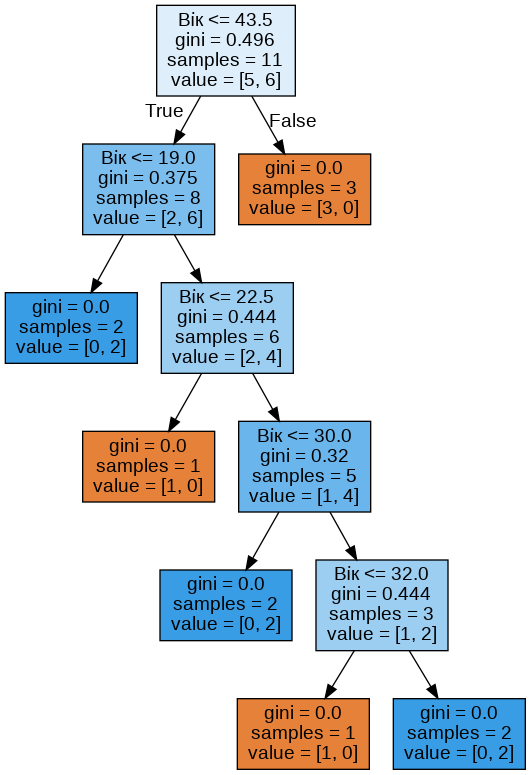

In [18]:
export_graphviz(age_tree, feature_names=['Вік'], 
                out_file='img/age_tree.dot', filled=True)
!dot -Tpng img/age_tree.dot -o img/age_tree.png

from IPython.display import Image
Image('img/age_tree.png', width=640, height=480)

Розглянемо приклад складніше: додамо ознаку "Зарплата" (тис. грн / місяць).

In [19]:
data2 = pd.DataFrame({'Вік':  [17,64,18,20,38,49,55,25,29,31,33], 
                      'Зарплата': [25,80,22,36,37,59,74,70,33,102,88], 
                      'Неповерення_кредиту': [1,0,1,0,1,0,0,1,1,0,1]})

In [20]:
data2

,Вік,Зарплата,Неповерення_кредиту
0,17,25,1
1,64,80,0
2,18,22,1
3,20,36,0
4,38,37,1
5,49,59,0
6,55,74,0
7,25,70,1
8,29,33,1
9,31,102,0


Якщо впорядкувати за віком, то цільовий клас ("Неповернення кредиту") змінюється (з 1 на 0 або навпаки) 5 разів. А якщо впорядкувати за зарплатою - то 7 разів. Як тепер дерево буде обирати ознаки? Подивимося.

In [21]:
data2.sort_values('Вік')

,Вік,Зарплата,Неповерення_кредиту
0,17,25,1
2,18,22,1
3,20,36,0
7,25,70,1
8,29,33,1
9,31,102,0
10,33,88,1
4,38,37,1
5,49,59,0
6,55,74,0


In [22]:
data2.sort_values('Зарплата')

,Вік,Зарплата,Неповерення_кредиту
2,18,22,1
0,17,25,1
8,29,33,1
3,20,36,0
4,38,37,1
5,49,59,0
7,25,70,1
6,55,74,0
1,64,80,0
10,33,88,1


In [23]:
age_sal_tree = DecisionTreeClassifier(random_state=17)
age_sal_tree.fit(data2[['Вік', 'Зарплата']].values, data2['Неповерення_кредиту'].values);

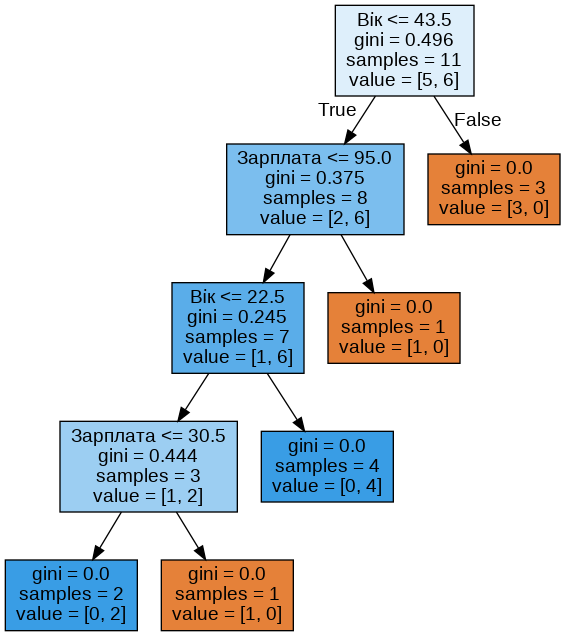

In [24]:
export_graphviz(age_sal_tree, feature_names=['Вік', 'Зарплата'], 
                out_file='img/age_sal_tree.dot', filled=True)
!dot -Tpng img/age_sal_tree.dot -o img/age_sal_tree.png

from IPython.display import Image
Image('img/age_sal_tree.png', width=640, height=480)

Бачимо, що в дереві задіяні як розбиття за віком, так і за зарплатою. Причому пороги, з якими порівнюються ознаки: 43.5 і 22.5  для віку, і 95 і 30.5 тис. грн / міс - для зарплати. І знову можна помітити, що 95 тис. - це середнє між 88 і 102, при цьому людина з зарплатою 88 виявилася "поганою", а з 102 - "хорошою". Те ж саме для 30.5 тис. Тобто перебиралися порівняння зарплати і віку не з усіма можливими значеннями, а тільки з кількома. А чому в дереві виявилися саме ці ознаки? Тому що по ним розбиття виявилися кращими (за критерієм невизначеності Джині).

**Висновок:** найпростіша евристика для обробки кількісних ознак в дереві рішень: кількісна ознака сортується в порядку зростання, і в дереві перевіряються тільки ті пороги, при яких цільова ознака змінює значення. Звучить не дуже строго, але сподіваюся, я доніс сенс за допомогою іграшкових прикладів.

Додатково, коли в даних багато кількісних ознак, і у кожної багато унікальних значень, можуть підбиратися не всі пороги, описані вище, а тільки топ-N, що дають максимальний приріст все того ж критерію. Тобто, по суті, для кожного порога будується дерево глибини 1, обчислюється наскільки знизилася ентропія (або невизначеність Джині) і вибираються тільки найкращі пороги, з якими варто порівнювати кількісну ознаку.

Для ілюстрації: при розбитті за ознакою "Зарплата $\leq$ 34.5" в лівій підгрупі ентропія 0 (всі клієнти "погані"), а в правій - 0.954 (3 "поганих" і 5 "хороших", можете перевірити). Приріст інформації виходить приблизно 0.3.
А при розбитті за ознакою "Зарплата $\leq$ 95" в лівій підгрупі ентропія 0.97 (6 "поганих" і 4 "хороших"), а в правій - 0 (всього один об'єкт). Приріст інформації виходить приблизно 0.11.
Порахувавши таким чином приріст інформації для кожного розбиття, можна попередньо, до побудови великого дерева (за всіма ознаками) відібрати пороги, з якими буде порівнюватися кожна кількісна ознака.

### Основні параметри дерева

В принципі дерево рішень можна побудувати до такої глибини, щоб в кожному листку був рівно один об'єкт. Але на практиці це не робиться через те, що таке дерево буде *перенавчатися* - надмірне налаштування на навчальну вибірку із-за чого будуть неточні прогнози на нових даних, які не входять до навчальної вибірки. Десь внизу дерева, на великій глибині будуть з'являтися розбиття по менш важливим ознакам (наприклад, до сумського відділу банку приїхав клієнт зі Львова або Тернополя). Можливо з деяким перебільшенням, але може виявитися так, що з усіх 4 клієнтів, які прийшли в банк за кредитом в зелених штанях, ніхто не повернув кредит. Але ми не хочемо, щоб наша модель класифікації породжувала такі специфічні правила.

Основні способи боротьби з перенавчанням у випадку дерев рішень:
 - штучне обмеження глибини або мінімального числа об'єктів в листку дерева: побудова дерева просто в якийсь момент припиняється;
 - підстригання дерева (* pruning *). При такому підході дерево спочатку будується до максимальної глибини, потім поступово, від низу до верху, деякі вершини дерева прибираються за рахунок порівняння за якістю дерева з даними розбиттям і без нього (порівняння проводиться за допомогою * крос-валідації *, про яку трохи нижче).

### Клас DecisionTreeClassifier в Scikit-learn
Основні параметри класу[sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):

- `max_depth` - максимальна глибина дерева
- `max_features` - максимальне число ознак, за якими шукається краще розбиття в дереві (це потрібно тому, що при великій кількості ознак буде "дорого" шукати краще (за критерієм типу приросту інформації) розбиття серед *всіх* ознак)
- `min_samples_leaf` - мінімальне число об'єктів в листку. У цього параметра є зрозуміла інтерпретація: скажімо, якщо він дорівнює 5, то дерево буде породжувати тільки ті класифікаційні правила, які правильні як мімімум для 5 об'єктів

Параметри дерева треба налаштовувати в залежності від вхідних даних, і робиться це зазвичай за допомогою  *крос-валідації*, про яку трохи нижче.

## Дерево рішень в задачі регресії
 
  Під час прогнозування кількісної ознаки ідея побудови дерева залишається та ж, але змінюється критерій якості: 
 
 - Дисперсія навколо середнього: $$\Large D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{i =1}^{\ell} y_i)^2, $$
 де $\ell$ – число об'єктів у листку, $y_i$ – значення цільової ознаки (мітки). По простому кажучи, мінімізуючи дисперсію навколо середнього, ми шукаємо ознаки, що розбивають вибірку таким чином, що значення цільової змінної в кожному листку приблизно рівні.

#### Приклад
Згенеруємо дані, розподілені згідно функції  $f(x) = e^{-x ^ 2} + 1.5 * e^{-(x - 2) ^ 2}$ c деяким шумом.

In [25]:
n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

In [26]:
from sklearn.tree import DecisionTreeRegressor
     
reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

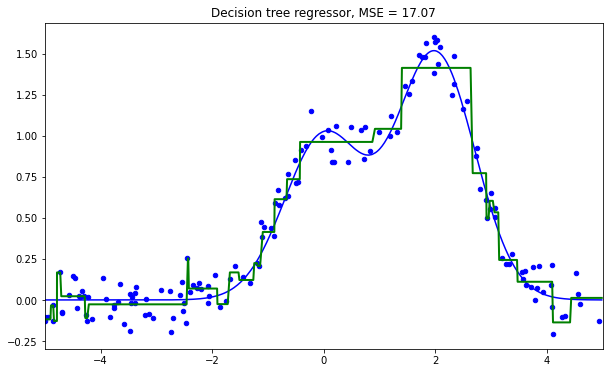

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

Бачимо, що дерево рішень аппроксимирує залежність в даних шматково-постійною функцією.

# Метод найближчих сусідів

Метод найближчих сусідів (k Nearest Neighbors, або kNN) - теж дуже популярний метод класифікації, також іноді використовується в задачах регресії. Цей метод, нарівні з деревом рішень, є одним з найбільш зрозумілих підходів до класифікації. На рівні інтуїції суть методу така: подивись на сусідів, які переважають - які вони, такий і ти. Формально основою методу є гіпотеза компактності: якщо метрика відстані між прикладами введена досить вдало, то схожі приклади набагато частіше лежать в одному класі, ніж в різних.

Згідно з методом найближчих сусідів, тестовий приклад (зелена кулька) буде віднесена до класу "сині", а не "червоні".



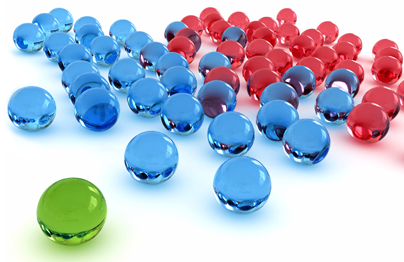

In [28]:
from IPython.display import Image
Image('img/kNN.png', width=640, height=480)

Наприклад, якщо не знаєш, який тип товару вказати в оголошенні для Bluetooth-гарнітури, можеш знайти 5 схожих гарнітур, і якщо 4 з них віднесені до категорії "Аксесуари", і тільки один - до категорії "Техніка", то здоровий глузд підкаже для свого оголошення теж вказати категорію "Аксесуари".

Для класифікації кожного з об'єктів тестової вибірки необхідно послідовно виконати наступні операції:
 - Обчислити відстань до кожного з об'єктів навчальної вибірки
 - Відібрати $k$ об'єктів навчальної вибірки, відстань до яких мінімальна
 - Клас об'єкта, що класифікується - це клас, який найчастіше трапляється серед $k$ найближчих сусідів
 
Примітна властивість такого підходу - його лінивість. Це означає, що обчислення починаються тільки в момент класифікації тестового прикладу, а заздалегідь ніяка модель не будується. У цьому відмінність, наприклад, від раніше розглянутого дерева рішень, де спочатку на основі навчальної вибірки будується дерево, а потім відносно швидко відбувається класифікація тестових прикладів.
 
Варто відзначити, що метод найближчих сусідів - добре вивчений підхід. Для методу найближчих сусідів існує чимало важливих теорем, які стверджують, що на "нескінченних" вибірках це оптимальний метод класифікації. Автори класичної книги "The Elements of Statistical Learning" вважають kNN теоретично ідеальним алгоритмом, застосовність якого просто обмежена обчислювальними можливостями і прокляттям розмірності.

### Метод найближчих сусідів в реальних задачах
- У чистому вигляді kNN може послужити хорошим стартом (baseline) у вирішенні будь-якої задачі;
- У змаганнях Kaggle kNN часто використовується для побудови мета-ознак (прогноз kNN подається на вхід іншим моделям) або в стекінг / Блендінг;
- Ідея найближчого сусіда розширюється і на інші завдання, наприклад, в рекомендаційних системах простим початковим рішенням може бути рекомендація якогось товару (або послуги), популярного серед *найближчих сусідів* людини, якій хочемо зробити рекомендацію;
- На практиці для великих вибірок часто користуються *наближеними* методами пошуку найближчих сусідів. 

Якість класифікації методом найближчих сусідів залежить від декількох параметрів:
 - число сусідів
 - метрика відстані між об'єктами (часто використовуються метрика Хеммінга, евклідова відстань, косинусна відстань і відстань Маньківського). Відзначимо, що при використанні більшості метрик значення ознак потрібно масштабувати (скейлити). Умовно кажучи, щоб ознака "Зарплата" з діапазоном значень до 100 тисяч не вносила більший вклад у відстань, ніж "Вік" зі значеннями до 100.
 - ваги сусідів (сусіди тестового прикладу можуть входити з різними вагами, наприклад, чим далі приклад, тим з меншим коефіцієнтом враховується його "голос")

 
### Клас KNeighborsClassifier в Scikit-learn
Основні параметри класу sklearn.neighbors.KNeighborsClassifier:
 - weights: "uniform" (всі ваги рівні), "distance" (вага обернено пропорційний відстані до тестового прикладу) або інша визначена користувачем функція
 - algorithm (опціонально): "brute", "ball_tree", "KD_tree", або "auto". У першому випадку найближчі сусіди для кожного тестового прикладу вважаються перебором навчальної вибірки. У другому і третьому - відстань між прикладами зберігаються в дереві, що прискорює знаходження найближчих сусідів. У разі зазначення параметра "auto" відповідний спосіб знаходження сусідів буде обрано автматично на основі навчальної вибірки.
 - leaf_size (опціонально): поріг перемикання на повний перебір в разі вибору BallTree або KDTree для знаходження сусідів
 - metric: "minkowski", "manhattan", "euclidean", "chebyshev" та інші

# Вибір параметрів моделі і крос-валідація

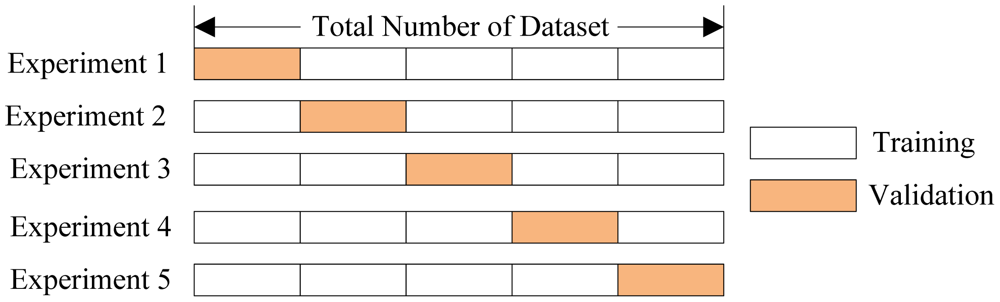

In [34]:
from IPython.display import Image
Image('img/cross_validation.png', width=640, height=480)

Головне завдання алгоритмів, що навчаються - їх здатність *узагальнювати*, тобто добре працювати на нових даних. Оскільки, на нових даних ми відразу не можемо перевірити якість побудованої моделі (нам же потрібно для них зробити прогноз, тобто істинних значень цільової ознаки ми для них не знаємо), то треба пожертвувати невеликою порцією даних, щоб на ній перевірити якість моделі.

Найчастіше це робиться одним з 2 способів:

 - відкладена вибірка (*held-out / hold-out set*). При такому підході ми залишаємо якусь частку навчальної вибірки (як правило від 20% до 40%), навчаємо модель на інших даних (60-80% вихідної вибірки) і вважаємо деяку метрику якості моделі (наприклад, найпростіше - частку правильних відповідей в задачі класифікації) на відкладеної вибірці.
 - крос-валідація (*cross-validation*, на українську ще перекладають як ковзний або перехресний контроль). Тут найчастіший випадок - K-fold крос-валідація
 


У даному випадку модель навчається K раз на різних (K-1) підвибірках вихідної вибірки (білий колір), а перевіряється на одній підвибірці (кожен раз на різній, помаранчевий колір).
Виходять $K$ оцінок якості моделі, які зазвичай усереднюються, видаючи середню оцінку якості класифікації / регресії на крос-валідації.

Крос-валідація дає кращу в порівнянні з відкладеною вибіркою оцінку якості моделі на нових даних. Але крос-валідація обчислювально дорога, якщо даних багато.

Крос-валідація - дуже важлива техніка в машинному навчанні (застосовується також у статистиці і економетриці), з її допомогою вибираються гіперпараметри моделей, порівнюються моделі між собою, оцінюється корисність нових ознак в завданні і т.д.

## Дерева рішень і метод найближчих сусідів у завданні прогнозування відтоку клієнтів телеком-оператора

Завантажимо дані в DataFrame і проведемо передобробку. Штати поки збережемо в окремий об'єкт Series, але видалимо з датафрейма. Першу модель будемо навчати без штатів, потім подивимося, чи допомагають вони.

In [33]:
df = pd.read_csv('data/telecom_churn.csv')

In [34]:
df['International plan'] = pd.factorize(df['International plan'])[0]
df['Voice mail plan']    = pd.factorize(df['Voice mail plan'])[0]
df['Churn']              = df['Churn'].astype('int')
states                   = df['State']
y = df['Churn']
df.drop(['State', 'Churn'], axis=1, inplace=True)

In [37]:
df.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,128,415,0,0,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1
1,107,415,0,0,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1
2,137,415,0,1,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0
3,84,408,1,1,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2
4,75,415,1,1,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3


In [38]:
from sklearn.model_selection import train_test_split, StratifiedKFold

Виділимо 70% вибірки (X_train, y_train) під навчання і 30% будуть відкладеної вибіркою (X_holdout, y_holdout). відкладена вибірка ніяк не братиме участі в налаштуванні параметрів моделей, на ній ми в кінці, після цієї настройки, оцінимо якість отриманої моделі.

In [39]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df.values, y, test_size=0.3, random_state=17)

Навчимо 2 моделі - дерево рішень і kNN, поки не знаємо, які параметри гарні, тому навмання: глибину дерева беремо 5, число найближчих сусідів - 10.

In [52]:
from sklearn.neighbors import KNeighborsClassifier

tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=15)

In [53]:
%%time
tree.fit(X_train, y_train)

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 23.5 ms


DecisionTreeClassifier(max_depth=5, random_state=17)

In [54]:
%%time
knn.fit(X_train, y_train)

CPU times: user 0 ns, sys: 775 µs, total: 775 µs
Wall time: 785 µs


KNeighborsClassifier(n_neighbors=15)

Якість прогнозів будемо перевіряти за допомогою простої метрики - частки правильних відповідей

In [55]:
from sklearn.metrics import accuracy_score

Зробимо прогнози для відкладеної вибірки. Бачимо, що дерево рішень впоралося набагато краще. Але це ми поки вибирали параметри навмання.

In [56]:
tree_pred = tree.predict(X_holdout)
accuracy_score(y_holdout, tree_pred)

0.94

In [57]:
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred)

0.881

Тепер налаштуємо параметри дерева на крос-валідації. Налаштовувати будемо максимальну глибину і максимальне число ознак, що використовуються на кожному розбитті. Суть того, як працює GridSearchCV: для кожної унікальної пари значень параметрів `max_depth` і `max_features` буде проведена 5-кратна крос-валідація і вибереться найкраще поєднання параметрів.

In [59]:
from sklearn.model_selection import GridSearchCV, cross_val_score

In [60]:
tree_params = {'max_depth': range(1,11),
               'max_features': range(4,19)}

In [61]:
tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1,
                         verbose=True)

In [62]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

Краще поєднання  параметрів і відповідна середня частка правильних відповідей на крос-валідації:

In [63]:
tree_grid.best_params_

{'max_depth': 6, 'max_features': 17}

In [64]:
tree_grid.best_score_

0.94257014456259

In [65]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.946

Тепер спробуємо налаштувати число сусідів в алгоритмі kNN.

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [68]:
knn_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier(n_jobs=-1))])

In [69]:
knn_params = {'knn__n_neighbors': range(1, 10)}

In [70]:
knn_grid = GridSearchCV(knn_pipe, knn_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [71]:
knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1, param_grid={'knn__n_neighbors': range(1, 10)},
             verbose=True)

In [72]:
knn_grid.best_params_, knn_grid.best_score_

({'knn__n_neighbors': 7}, 0.8859867109023905)

In [73]:
accuracy_score(y_holdout, knn_grid.predict(X_holdout))

0.89

Бачимо, що в цьому прикладі дерево показало себе краще, ніж метод найближчих сусідів. Більш того, в даній задачі дерево проявляє себе дуже добре, і навіть випадковий ліс (який поки представляємо просто як купу дерев, які разом працюють чомусь набагато краще, ніж одне дерево) в цьому прикладі показує частку правильних відповідей не набагато вище (як на крос-валідації, так і на відкладеної вибірці), а навчається набагато довше.

In [74]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17)
print(np.mean(cross_val_score(forest, X_train, y_train, cv=5)))

0.9494233119813256


In [75]:
forest_params = {'max_depth': range(1,11),
               'max_features': range(4,19)}

In [76]:
forest_grid = GridSearchCV(forest, forest_params,
                         cv=5, n_jobs=-1,
                         verbose=True)

In [77]:
forest_grid.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 11),
                         'max_features': range(4, 19)},
             verbose=True)

In [78]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 9, 'max_features': 6}, 0.9511372931045574)

In [79]:
accuracy_score(y_holdout, forest_grid.predict(X_holdout))

0.953

Намалюємо вийшло дерево. Через те, що воно не зовсім іграшкове (максимальна глибина - 6), картинка виходить вже не маленькою, але по дерево можна "прогулятися", якщо окремо відкрити малюнок.

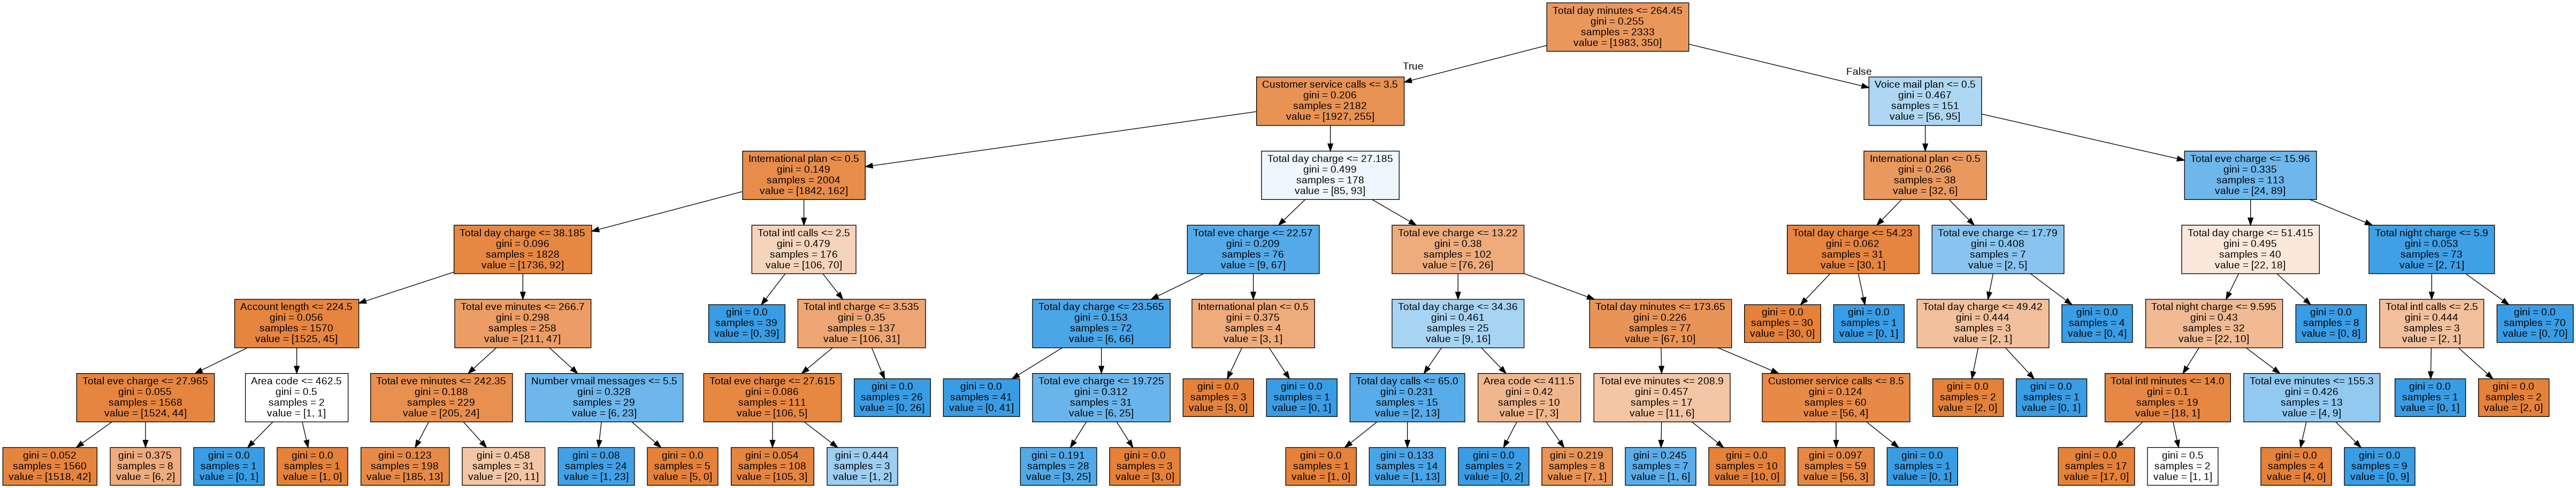

In [80]:
export_graphviz(tree_grid.best_estimator_, feature_names=df.columns, 
                out_file='img/churn_tree.dot', filled=True)
!dot -Tpng img/churn_tree.dot -o img/churn_tree.png

from IPython.display import Image
Image('img/churn_tree.png') #, width=640, height=480)

## Дерева рішень і метод найближчих сусідів в задачі розпізнавання рукописних цифр MNIST

Тепер подивимося на описані 2 алгоритми в реальній задачі. Використовуваний "вбудовані" в `sklearn` дані по рукописним цифрам. Це завдання буде прикладом, коли метод найближчих сусідів працює на диво добре.

In [81]:
from sklearn.datasets import load_digits

Завантажуємо дані.

In [82]:
data = load_digits()
X, y = data.data, data.target

Картинки тут представляються матрицею 8 x 8 (інтенсивності білого кольору для кожного пікселя). Далі ця матриця "розгортається" в вектор довжини 64, виходить признаковий опис об'єкта.

In [83]:
X[0,:].reshape([8,8])

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

Намалюємо кілька рукописних цифр, бачимо, що вони вгадуються.

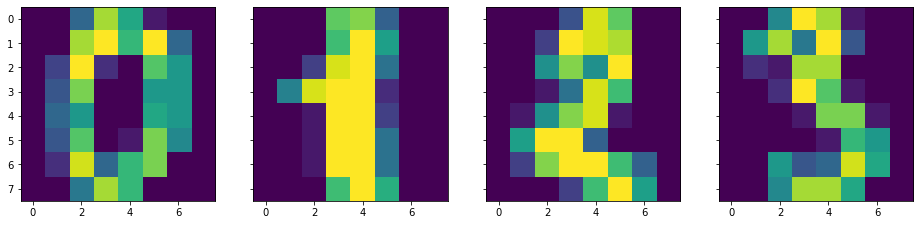

In [85]:
f, axes = plt.subplots(1, 4, sharey=True, figsize=(16,6))
for i in range(4):
    axes[i].imshow(X[i,:].reshape([8,8]));


Подивимося на співвідношення класів у вибірці, бачимо, що приблизно порівну нулів, одиниць, ..., дев'яток.

In [ ]:
np.bincount(y)

array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180])

Виділимо 70% вибірки (X_train, y_train) під навчання і 30% будуть відкладеною вибіркою (X_holdout, y_holdout). відкладена вибірка ніяк не братиме участі в налаштуванні параметрів моделей, на ній ми в кінці, після цієї настройки, оцінимо якість отриманої моделі.

In [86]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=17)

Навчимо дерево рішень і kNN, знову параметри поки навмання беремо.

In [87]:
tree = DecisionTreeClassifier(max_depth=5, random_state=17)
knn = KNeighborsClassifier(n_neighbors=10)

In [88]:
%%time
tree.fit(X_train, y_train)

CPU times: user 15.1 ms, sys: 776 µs, total: 15.9 ms
Wall time: 17.6 ms


DecisionTreeClassifier(max_depth=5, random_state=17)

In [89]:
%%time
knn.fit(X_train, y_train)

CPU times: user 1.73 ms, sys: 0 ns, total: 1.73 ms
Wall time: 1.66 ms


KNeighborsClassifier(n_neighbors=10)

Зробимо прогнози для відкладеної вибірки. Бачимо, що метод найближчих сусідів впорався набагато краще. Але це ми поки вибирали параметри навмання.

In [90]:
tree_pred = tree.predict(X_holdout)
knn_pred = knn.predict(X_holdout)
accuracy_score(y_holdout, knn_pred), accuracy_score(y_holdout, tree_pred)

(0.9740740740740741, 0.6666666666666666)

Тепер так само, як раніше налаштуємо параметри моделей на крос-валідації, тільки врахуємо, що ознак зараз більше, ніж в минулому завданні - 64.

In [91]:
tree_params = {'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
               'max_features': [1, 2, 3, 5, 10, 20 ,30, 50, 64]}

In [92]:
tree_grid = GridSearchCV(tree, tree_params,
                         cv=5, n_jobs=-1,
                        verbose=True)

In [93]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=5, random_state=17),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 10, 20, 25, 30, 40, 50, 64],
                         'max_features': [1, 2, 3, 5, 10, 20, 30, 50, 64]},
             verbose=True)

Лучшее сочетание параметров и соответствующая средняя доля правильных ответов на кросс-валидации:

In [94]:
tree_grid.best_params_, tree_grid.best_score_

({'max_depth': 10, 'max_features': 50}, 0.8568203376968316)

In [95]:
accuracy_score(y_holdout, tree_grid.predict(X_holdout))

0.8425925925925926

Це вже не 66%, але і не 97%. Метод найближчих сусідів на цьому наборі даних працює краще. У разі одного найближчого сусіда на крос-валідації досягається майже 99% вгадувань.

In [96]:
np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X_train, y_train, cv=5))

0.9864858028204642

In [97]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
accuracy_score(y_holdout, knn.predict(X_holdout))

0.9833333333333333

Навчимо на цих же даних випадковий ліс, він на більшості вибірок працює краще, ніж метод найближчих сусідів. Але зараз у нас виняток.

In [98]:
np.mean(cross_val_score(RandomForestClassifier(random_state=17), X_train, y_train, cv=5))

0.9753462341111744

In [99]:
rf = RandomForestClassifier(random_state=17, n_jobs=-1).fit(X_train, y_train)
accuracy_score(y_holdout, rf.predict(X_holdout))

0.9666666666666667

Ви матимете рацію, якщо заперечите, що ми тут не налаштовували параметри RandomForestClassifier, але навіть з налаштуванням частка правильних відповідей не досягає 98%, як для у методу одного найближчого сусіда.

Результати експерименту:

|     |   CV  | Holdout |  
|-----|:-----:|:-------:|
| **DT**  | 0.844 |  0.838  |  
| **kNN** | 0.987 |  0.983  |
| **RF**  | 0.935 |  0.941  | 

Позначення: CV та Holdout- середні частки правильних відповідей моделі на крос-валідації і відкладеної вибірці відповідно. DT - дерево рішень, kNN - метод найближчих сусідів, RF - випадковий ліс


**Висновок** з цього експерименту (і загальна порада): на початку перевіряйте на своїх даних прості моделі - дерево рішень і метод найближчих сусідів, може виявитися, що вже вони працюють досить добре.

## Плюси і мінуси дерев рішень

**Плюси:**
 - Породження чітких правил класифікації, зрозумілих людині, наприклад, "якщо вік <25 та інтерес до мотоциклів, то відмовити в кредиті". Це властивість називають інтерпретованістю моделі;
 - Дерева рішень можуть легко візуалізувати, тобто може "інтерпретуватися"  як сама модель (дерево), так і прогноз для окремого взятого тестового об'єкта (шлях в дереві);
 - Швидкі процеси навчання і прогнозування;
 - Мале число параметрів моделі;
 - Підтримка і числових, і категоріальних ознак.
 
**Мінуси:**
 - У породження чітких правил класифікації є й інша сторона: дерева дуже чутливі до шумів у вхідних даних, вся модель може кардинально змінитися, якщо трохи зміниться навчальна вибірка (наприклад, якщо прибрати одну з ознак або додати кілька об'єктів), тому і правила класифікації можуть сильно змінюватися;
 - Розділяюча межа, побудована деревом рішень, має свої обмеження, і на практиці дерево рішень за якістю класифікації поступається деяким іншим методам;
 - Необхідність відсікати гілки дерева (pruning) або встановлювати мінімальне число елементів в листі дерева або максимальну глибину дерева для боротьби з перенавчанням. Втім, перенавчання - проблема всіх методів машинного навчання;
 - Нестабільність. Невеликі зміни в даних можуть суттєво змінювати побудоване дерево рішень. З цією проблемою борються за допомогою ансамблів дерев рішень;
 - Проблема пошуку оптимального дерева рішень (мінімального за розміром і здатного без помилок класифікувати вибірку) NP-повна, тому на практиці використовуються евристики типу жадібного пошуку ознаки з максимальним приростом інформації, які не гарантують знаходження глобально оптимального дерева;
 - Складно підтримуються пропуски в даних. Friedman оцінив, що на підтримку пропусків в даних пішло близько 50% коду CART (класичний алгоритм побудови дерев класифікації і регресії - Classification And Regression Trees, в `sklearn` реалізована поліпшена версія саме цього алгоритму);
 - Модель вміє тільки інтерполювати, але не екстраполювати (це ж вірно і для лісу та бустінга на деревах). Тобто дерево рішень робить константний прогноз для об'єктів, що перебувають у просторі ознак поза паралелепіпом, що охоплює всі об'єкти навчальної вибірки. У нашому прикладі з жовтими і синіми кульками це означає, що модель дає однаковий прогноз для всіх кульок з координатою > 19 або <0.


### Плюси і мінуси методу найближчих сусідів

Плюси:
  - Проста реалізація
  - Можна адаптувати під потрібне завдання вибором метрики або ядра (в двох словах: ядро може задавати операцію подібності для складних об'єктів типу графів, а сам підхід kNN залишається тим же);
 - Непогана інтерпретація, можна пояснити, чому тестовий приклад був класифікований саме так. Хоча цей аргумент можна атакувати: якщо число сусідів велика, то інтерпретація погіршується (умовно: "ми не дали йому кредит, тому що він схожий на 350 клієнтів, у тому числі 70 - погані, що на 12% більше, ніж в середньому по вибірці" ).
 
Мінуси:
 - Метод вважається найшвидшим у порівнянні, наприклад, з композиціями алгоритмів, але в реальних задачах, як правило, число сусідів, які використовуються для класифікації, буде великим (100-150), і в такому випадку алгоритм буде працювати не так швидко, як дерево рішень;
 - Якщо в наборі даних багато ознак, то важко підібрати відповідні ваги і визначити, які ознаки не важливі для класифікації / регресії;
 - Залежність від обраної метрики відстані між прикладами. Вибір за замовчуванням евклідової відстані найчастіше нічим не обгрунтований. Можна відшукати хороше рішення перебором параметрів, але для великого набору даних це забирає багато часу;
 - Немає теоретичних підстав вибору певного числа сусідів - тільки перебір (втім, найчастіше це вірно для всіх гіперпараметрів всіх моделей). У разі малого числа сусідів метод чутливий до викидів, тобто схильний перенавчатися;
 - Як правило, погано працює, коли ознак багато, через "проякляття розмірності".
 

### Складний випадок для дерев
В продовження обговорення плюсів і мінусів наведемо дуже простий приклад завдання класифікації, з яким дерево справляється, але робить все якось "складніше", ніж хотілося б. Створимо безліч точок на площині (2 ознаки), кожна точка буде належати до одного з класів (+1, червоні, або -1 - жовті). Якщо дивитися на це як на задачу класифікації, то начебто все дуже просто - класи розділяються прямою.

In [ ]:
def form_linearly_separable_data(n=500, x1_min=0, x1_max=30, x2_min=0, x2_max=30):
    data, target = [], []
    for i in range(n):
        x1, x2 = np.random.randint(x1_min, x1_max), np.random.randint(x2_min, x2_max)
        
        if np.abs(x1 - x2) > 0.5:
            data.append([x1, x2])
            target.append(np.sign(x1 - x2))
    return np.array(data), np.array(target)

In [ ]:
X, y = form_linearly_separable_data()

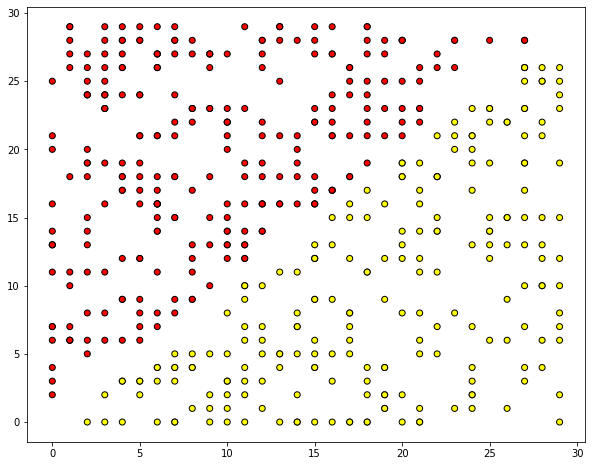

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', edgecolors='black');

Однак дерево рішень будує аж надто складний кордон і саме по собі виявляється глибоким. Крім того, уявіть, як погано дерево буде узагальнюватися на простір поза представленого квадрата $30 \times 30$,що обрамляє навчальну вибірку.

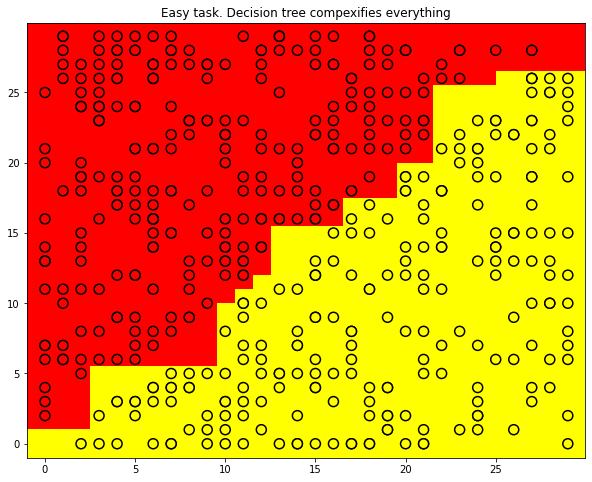

In [ ]:
tree = DecisionTreeClassifier(random_state=17).fit(X, y)

xx, yy = get_grid(X, eps=.05)
predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5)
plt.title('Easy task. Decision tree compexifies everything');

Ось така складна конструкція, хоча рішення (хороша розділяєча поверхня) - це всього лише пряма $x_1 = x_2$.

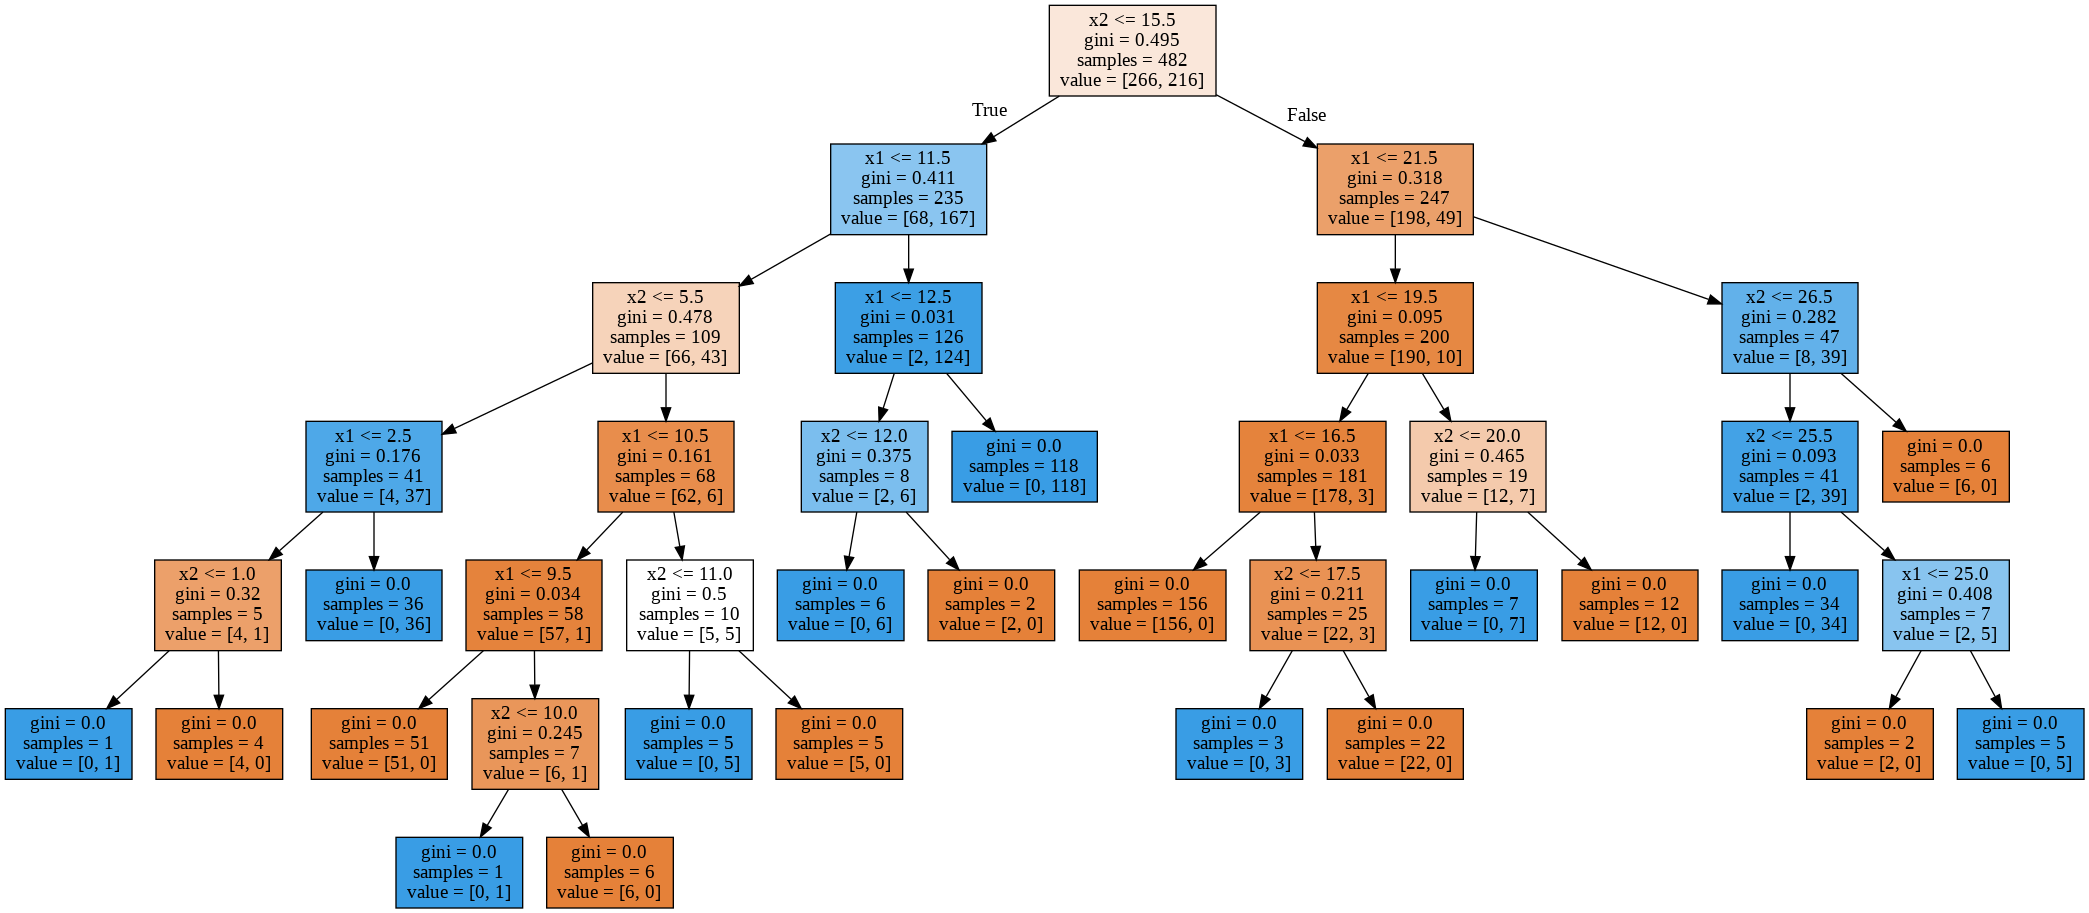

In [ ]:
export_graphviz(tree, feature_names=['x1', 'x2'], 
                out_file='img/deep_toy_tree.dot', filled=True)
!dot -Tpng img/deep_toy_tree.dot -o img/deep_toy_tree.png

from IPython.display import Image
Image('img/deep_toy_tree.png') #, width=640, height=480)

Метод одного найближчого сусіда тут справляється начебто краще дерева, але все ж не так добре, як лінійний класифікатор (наша наступна тема).

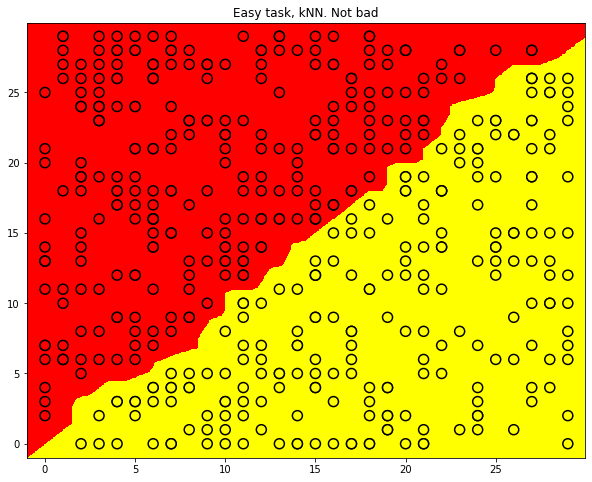

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X, y)

xx, yy = get_grid(X, eps=.05)
predicted = knn.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);
plt.title('Easy task, kNN. Not bad');

### Складний випадок для методу найближчих сусідів
Тепер розглянемо ще один простий приклад. У задачі класифікації одна з ознак буде просто пропорційний вектору відповідей, але методу найближчих сусідів це не допоможе.

In [ ]:
def form_noisy_data(n_obj=1000, n_feat=100, random_seed=17):
    np.seed = random_seed
    y = np.random.choice([-1, 1], size=n_obj)
    
    # первый признак пропорционален целевому
    x1 = 0.3 * y
    
    # остальные признаки – шум
    
    x_other = np.random.random(size=[n_obj, n_feat - 1])
    
    return np.hstack([x1.reshape([n_obj, 1]), x_other]), y

In [ ]:
X, y = form_noisy_data()

Як завжди, будемо дивитися на частку правильних відповідей на крос-валідації і на відкладеної вибірці. Побудуємо криві, що відображають залежність цих величин від параметра `n_neighbors` в методі найближчих сусідів. Такі криві називаються кривими валідації.

In [ ]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3,
                                                          random_state=17)

Бачимо, що метод найближчих сусідів з евклідової метрикою не справляється із завданням, навіть якщо варіювати число найближчих сусідів в широкому діапазоні. Навпаки, дерево рішень легко "виявляє" приховану залежність в даних при будь-яке обмеження на максимальну глибину.

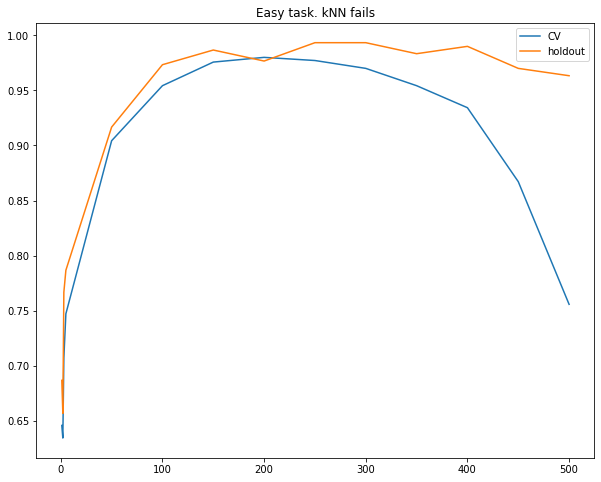

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores, holdout_scores = [], []
n_neighb = [1, 2, 3, 5] + list(range(50, 550, 50))

for k in n_neighb:

    knn = KNeighborsClassifier(n_neighbors=k)
    cv_scores.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    knn.fit(X_train, y_train)
    holdout_scores.append(accuracy_score(y_holdout, knn.predict(X_holdout)))

plt.plot(n_neighb, cv_scores, label='CV')
plt.plot(n_neighb, holdout_scores, label='holdout')
plt.title('Easy task. kNN fails')
plt.legend();

In [ ]:
tree = DecisionTreeClassifier(random_state=17, max_depth=1)
tree_cv_score = np.mean(cross_val_score(tree, X_train, y_train, cv=5))
tree.fit(X_train, y_train)
tree_holdout_score = accuracy_score(y_holdout, tree.predict(X_holdout))
print('Decision tree. CV: {}, holdout: {}'.format(tree_cv_score, tree_holdout_score))

Decision tree. CV: 1.0, holdout: 1.0


Отже, у другому прикладі дерево впоралося з завданням ідеально, а метод найближчих сусідів має труднощі. Втім, це мінус скоріше не методу, а використовуваної евклідової метрики: в даному випадку вона не дозволила виявити, що одна ознака набагато краще за інших.
